# Milestone 2 : Nettoyage et prétraitement des questions

## Libraries & Settings

In [ ]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mlt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')

#settings
# style for all plots
sns.set_style("darkgrid")
sns.set_palette("vlag")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2})
sns.set(rc={
    'axes.labelsize': 10,      
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,    
    'axes.labelcolor': 'gray', 
    'xtick.color': 'gray', 
    'ytick.color': 'gray',
    'axes.titlesize': 12,    
})

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\lzeferino\AppData\Roaming\nltk_data...
[nltk_data]   Package maxe

## Load Data

In [26]:
df = pd.read_csv("C:/Users/lzeferino/Downloads/QueryResults.csv")
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  0 non-null      float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB
None


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How to convert Decimal to Double in C#?,"<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opacity&quot;.</p>\n<pre class=""lang-cs prettyprint-override""><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the app it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type decimal to double</p>\n</blockquote>\n",<c#><floating-point><type-conversion><double><decimal>,4,812,78485,NaN,13


#### Observations about the data

**Data Structure**
   - The dataset contains **50,000 entries** with 8 columns in total.

**Columns Overview**
   - **Title:** This column contains the titles of questions. It is a crucial feature since it often summarizes the question.
   - **Body:** This column contains the main content of the questions. Like the title, all 50,000 entries are non-null.
   - **Tags:** This column contains tags associated with each question, and all entries are non-null. These tags typically represent the key topics or technologies related to the question.
   - **Id:** A unique identifier for each question.
   - **Score:** This column represents the score or rating of each question. It contains non-null integer values for all entries, indicating user engagement.
   - **ViewCount:** This column indicates how many times each question has been viewed. It has non-null values for all entries.
   - **FavoriteCount:** This column contains only null values (`NaN`) across the entire dataset.
   - **AnswerCount:** This column contains non-null integer values for all entries and represents the number of answers each question has received.

**Observations**
   - **Title and Body:** These two columns will require preprocessing. They will be used for creating new features.
   - **Tags:** The tags provide predefined categories or topics. Can be helpful for supervised machine learning. 
   - **Score and ViewCount:** Higher scores and view counts might indicate better-quality questions or topics of higher interest.
   - **AnswerCount:** This can be used to assess the popularity and relevance of a question. More answers generally suggest higher engagement from the community.
   - **FavoriteCount and Id:**: Need to be removed

## Preprocessing

In [27]:
# Sample 10% of the data
# df = df.sample(frac=0.2, random_state=42)

# Drop unnecessary columns
df.drop(columns=['Id', 'FavoriteCount', 'Score', 'ViewCount', 'AnswerCount'], inplace=True)

### Cleaning Target column

In [28]:
def preprocess_y(word):
    words = re.findall(r'(?<=<)(.*?)(?=>)', word) # Extract words between angle brackets
    words = ' '.join(words) # Combine extracted words into a single string for further processing
    words = re.sub(r'\d+', '', words)  # Remove all numbers
    words = re.sub(r'\.(?!net\b)', ' ', words) # Preserve ".net" and remove periods from other words
    words = re.sub(r"[^c\#|c\+\+|\.net|\w\s]", " ", words)  # Keep only alphanumeric characters and specified languages (C#, C++, .NET)  
   
    processed_words = []
    for w in words.split():  # Split hyphenated words into separate words
        split_words = w.split('-')        
        processed_words.extend(split_words)  # Add all split words to the list
    processed_words = [w for w in processed_words if 2 <= len(w) <= 20]
    return processed_words

# Apply the function
df['Tags'] = df['Tags'].apply(preprocess_y)


### Preprocess "Body" and "Title"

In [29]:
# Cleanning---------------------
def clean_text(sentence):
    # Remove HTML tags
    soup = BeautifulSoup(sentence, "html.parser")
    sentence = soup.get_text()
    
    # Lowercase the text
    sentence = sentence.lower()

    # Remove special characters except for allowed ones
    sentence = re.sub(r"[^c\#|c\+\+|\.net|\w\s]", "", sentence)  
    
    # Remove all numbers
    sentence = re.sub(r'\d+', '', sentence)  
    
    # Remove words containing underscores and any other unwanted characters
    sentence = ' '.join([word for word in sentence.split() if '_' not in word and word.isascii() and not any(char.isdigit() for char in word)])
    
    # Remove extra whitespace
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    
    return sentence

# applying
# df['Title_clean'] = df['Title'].apply(clean_text)
# df['Body_clean'] = dfBody'].apply(clean_text)
# df.head(2)

In [30]:
# Tokenize sentence ---------------
from nltk.tokenize import RegexpTokenizer
def tokenize_text(cleaned_sentence):
    tokenizer = RegexpTokenizer(r"(c\#|c\+\+|\.net|\w+)")
    tokens = tokenizer.tokenize(cleaned_sentence)
    return tokens

In [31]:
# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english')))

def stop_word_filter(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) >= 2]
    return filtered_w2

In [32]:
# Lemmatizer 
from nltk.stem import WordNetLemmatizer
def lemma_words(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w, pos='v') for w in list_words] # (base d'un mot - verb)
    return lem_w

The reason you have different transformation functions for bag-of-words (BoW) and deep learning (DL) models stems from the different ways these models process text and their respective needs for feature representation.

1. Bag of Words (BoW): 
   - In models like CountVectorizer, Tf-idf, or Word2Vec, the text is treated as a collection of words where the frequency or importance of words matters.
   - These models often work better with text that is cleaned more aggressively. For example, removing stop words, punctuation, converting everything to lowercase, and lemmatizing or stemming the words helps reduce the dimensionality and makes the word counts or tf-idf features more meaningful.
   - Lemmatization, lowercasing, and stop-word removal ensure that different forms of the same word (e.g., "run," "running") are treated as the same word, reducing redundancy and making the representation more efficient for traditional machine learning models.

2. Deep Learning (e.g., BERT, USE):
   - In deep learning models, which often use word embeddings, the models learn complex semantic relationships between words, so they don't rely on simple word counts or frequencies.
   - These models handle some level of linguistic complexity internally and can learn the meanings of words in context. Hence, there's less need to aggressively clean the data by removing stop words or lemmatizing words. These transformations might strip away useful context that models like BERT use to understand sentence structure and meaning.
   - The deep learning models often benefit from keeping the text closer to its original form, though lowercasing is still often useful as it prevents the model from treating "Apple" and "apple" as completely unrelated tokens.

- **BoW-based models** benefit from aggressive preprocessing (stop-word removal, lemmatization) to reduce the vocabulary size and improve model performance by focusing on key words.
- **Deep learning models** (USE, BERT) benefit from keeping the text more intact, as they can handle richer linguistic structures and learn from the contextual relationships between words.

* Preprocessing functions for Bow and Deep Learning

In [33]:
# Fonction de préparation du texte pour le bag of words avec lemmatization (Countvectorizer et Tf_idf, Word2Vec)
def preprocess_bow(desc_text) :
    clean_df = clean_text(desc_text)
    word_tokens = tokenize_text(clean_df)
    sw = stop_word_filter(word_tokens)    
    lem_w = lemma_words(sw)    
    #preprocess_text = ' '.join(lem_w)
    return lem_w

# applying
df['title_clean_bow'] = df['Title'].apply(preprocess_bow)
df['body_clean_bow'] = df['Body'].apply(preprocess_bow)
df.head(2)

C:\Users\lzeferino\AppData\Local\Temp\ipykernel_24824\1766870745.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence, "html.parser")


,Title,Body,Tags,title_clean_bow,body_clean_bow
0,How to convert Decimal to Double in C#?,"<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opacity&quot;.</p>\n<pre class=""lang-cs prettyprint-override""><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the app it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type decimal to double</p>\n</blockquote>\n","[c#, floating, point, type, conversion, double, decimal]","[convert, decimal, double, c#]","[want, assign, decimal, variable, trans, double, variable, opacity, decimal, trans, trackbar, value, opacity, trans, build, app, give, follow, error, cannot, implicitly, convert, type, decimal, double]"
1,Calculate relative time in C#,"<p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n<ul>\n<li><code>2 hours ago</code></li>\n<li><code>3 days ago</code></li>\n<li><code>a month ago</code></li>\n</ul>\n","[c#, datetime, time, datediff, relative, time, span]","[calculate, relative, time, c#]","[give, specific, datetime, value, display, relative, time, like, hours, ago, days, ago, month, ago]"


## EDA

### Length distribution

In [34]:
# print(len(df['title_clean_bow'][0]))
df['len_title_bow'] = df['title_clean_bow'].apply(lambda x: len(x))
print('Max length Title BoW:', df['len_title_bow'].max())

df['len_body_bow'] = df['body_clean_bow'].apply(lambda x: len(x))
print('Max length Body BoW:', df['len_body_bow'].max())

df['len_tags'] = df['Tags'].apply(lambda x: len(x))
print('Max length Tags:', df['len_tags'].max())

Max length Title BoW: 19
Max length Body BoW: 2421
Max length Tags: 14


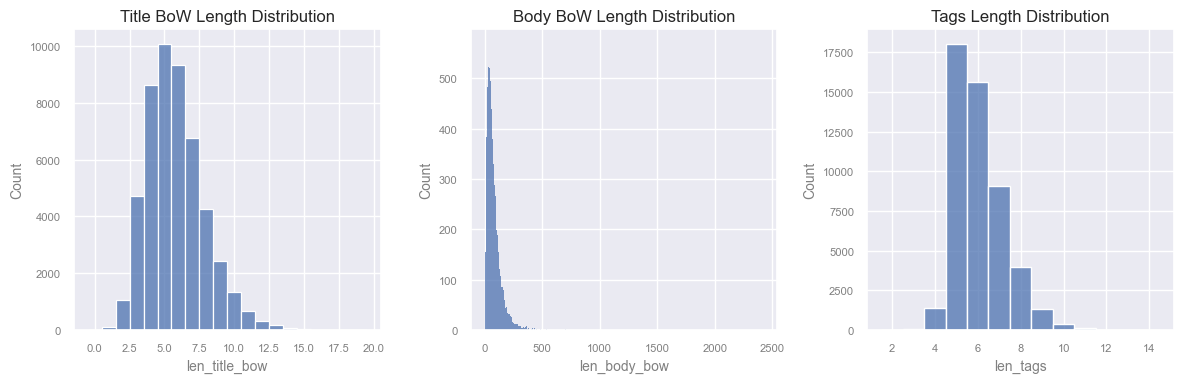

In [35]:
# Viz the distrivution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(df, x='len_title_bow', discrete=True, ax=axes[0])
axes[0].set_title('Title BoW Length Distribution')

sns.histplot(df, x='len_body_bow', discrete=True, ax=axes[1])
axes[1].set_title('Body BoW Length Distribution')

sns.histplot(df, x='len_tags', discrete=True, ax=axes[2])
axes[2].set_title('Tags Length Distribution')
plt.tight_layout()
plt.show()

Truncate features to improve model performance

In [36]:
# Truncate the body column to X amount of words
print('Lists > 250 words:', (df['len_body_bow'] > 250).sum())
max_lenght_body = 250
df['body_clean_bow'] = df['body_clean_bow'].apply(lambda x: x[:max_lenght_body])

Lists > 250 words: 1690


### Word analysis

* https://docs.python.org/3/library/collections.html#counter-objects
* A Counter is a dict subclass for counting hashable objects. It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values.

In [37]:
from collections import Counter

# Flatten the list of words in the Tittle and Body columns
title_bow_words = [word for tokens in df['title_clean_bow'] for word in tokens]
body_bow_words = [word for tokens in df['body_clean_bow'] for word in tokens]
tags_words = [word for tokens in df['Tags'] for word in tokens]
print('Unique words in Title BoW:', len(set(title_bow_words)))
print('Unique words in Body BoW:', len(set(body_bow_words)))
print('Unique words in Tags:', len(set(tags_words)))

# Count the frequency of each word - Creates a dictionary
title_bow_word_counts = Counter(title_bow_words)
body_bow_word_counts = Counter(body_bow_words)
tags_word_counts = Counter(tags_words)

# Transformin the dic in df
title_bow_df = pd.DataFrame(title_bow_word_counts.items(), columns=['word', 'freq'])
body_bow_df = pd.DataFrame(body_bow_word_counts.items(), columns=['word', 'freq'])
tags_df = pd.DataFrame(tags_word_counts.items(), columns=['word', 'freq'])

Unique words in Title BoW: 20806
Unique words in Body BoW: 224835
Unique words in Tags: 9734


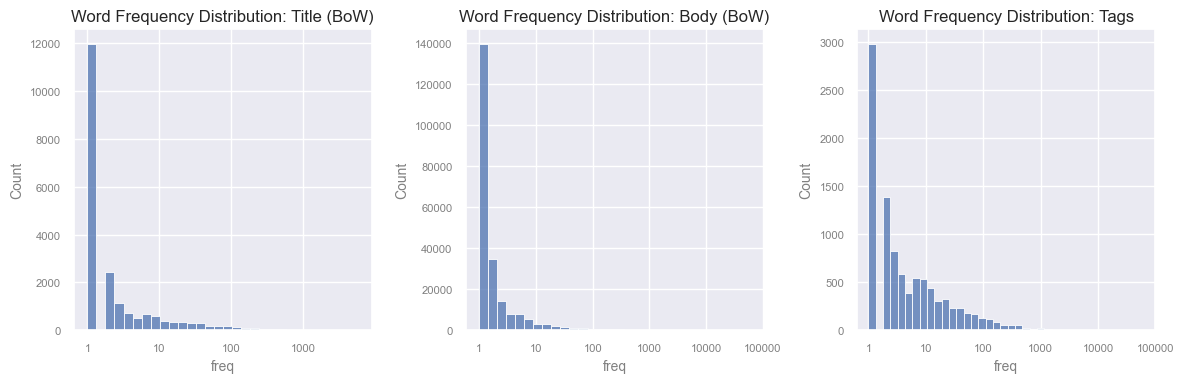

In [38]:
# Plot the distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(title_bow_df['freq'], bins=30, ax=axes[0], log_scale=True,)
axes[0].xaxis.set_major_formatter(mlt.ticker.ScalarFormatter())
axes[0].set_xticks([1, 10, 100, 1000])
axes[0].set_title('Word Frequency Distribution: Title (BoW)')

sns.histplot(body_bow_df['freq'], bins=30, ax=axes[1], log_scale=True,)
axes[1].xaxis.set_major_formatter(mlt.ticker.ScalarFormatter())
axes[1].set_xticks([1, 10, 100, 1000, 10000, 100000])
axes[1].set_title('Word Frequency Distribution: Body (BoW)')

sns.histplot(tags_df['freq'], bins=30, ax=axes[2], log_scale=True,)
axes[2].xaxis.set_major_formatter(mlt.ticker.ScalarFormatter())
axes[2].set_xticks([1, 10, 100, 1000, 10000, 100000])
axes[2].set_title('Word Frequency Distribution: Tags')

plt.tight_layout()

In [39]:
title_bow_df.nlargest(100, 'freq')

,word,freq
14,use,5761
34,file,2822
27,.net,2070
46,java,1997
12,get,1918
...,...,...
179,event,456
350,search,454
363,update,449
422,different,449


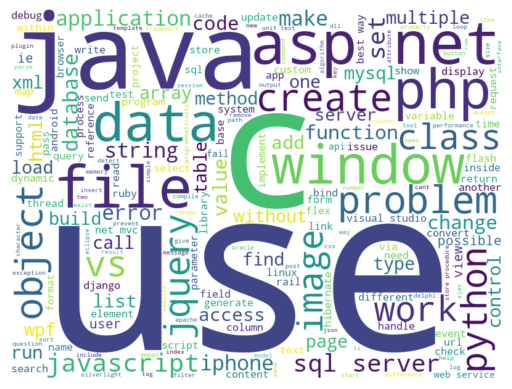

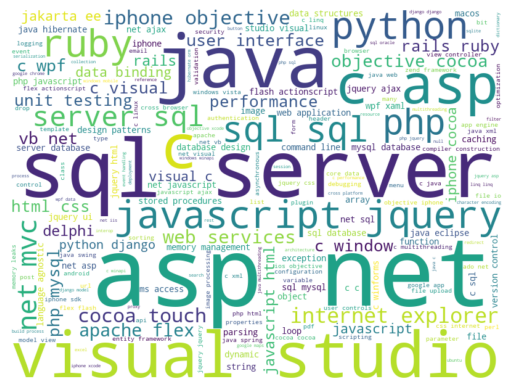

In [40]:
from wordcloud import WordCloud
str_title_bow = ' '.join(title_bow_words)
wc = WordCloud(width=800, height=600, background_color='white').generate(str_title_bow)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

from wordcloud import WordCloud
str_tags_bow = ' '.join(tags_words)
wc = WordCloud(width=800, height=600, background_color='white').generate(str_tags_bow)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

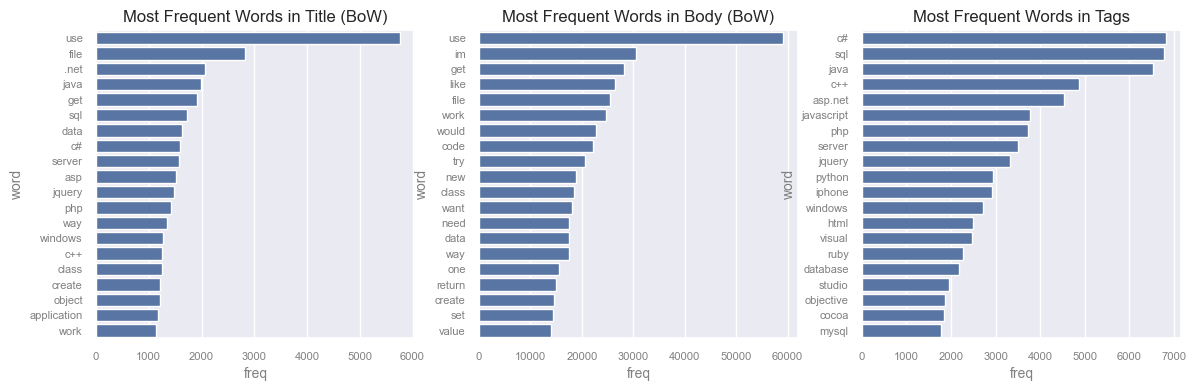

In [41]:
# Get the top X most frequent words
top_title_bow_df = title_bow_df.nlargest(20, 'freq')
top_body_bow_df = body_bow_df.nlargest(20, 'freq')
top_tags_df = tags_df.nlargest(20, 'freq')

# Plot the most frequent words
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.barplot(top_title_bow_df, x='freq', y='word', ax=axes[0])
axes[0].set_title('Most Frequent Words in Title (BoW)');

sns.barplot(top_body_bow_df,x='freq', y='word', ax=axes[1])
axes[1].set_title('Most Frequent Words in Body (BoW)');

sns.barplot(top_tags_df,x='freq', y='word', ax=axes[2])
axes[2].set_title('Most Frequent Words in Tags');

## Multi Label Binarizer

In [42]:
# Initialize and fit-transform the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tags'])
y = pd.DataFrame(y, columns=mlb.classes_)

# Count the number of occurrences for each tag
tag_counts = y.sum().sort_values(ascending=False)

# Display the top N popular tags
top_n = 20
top_tags = tag_counts.head(top_n).index

# Filter the DataFrame to only include the top N tags
y = y[top_tags]
y.head(1)

,c#,java,c++,asp.net,sql,javascript,php,iphone,jquery,python,server,windows,html,database,visual,objective,mysql,ruby,web,studio
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Split Train/Test

In [43]:
# Combine "Title" and "Body" for the Bag of Words approach
df['combined_text_bow'] = df['title_clean_bow'] + df['body_clean_bow'] 
df['combined_text_bow'] = df['combined_text_bow'].apply(lambda x: ' '.join(x)) # Join the list of words into a string
X = df['combined_text_bow']

In [44]:
# Split the dfs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)
print('y Train Shape:', y_train.shape)
print('y Test Shape:', y_test.shape)

# Save the target variables
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

X Train Shape: (40000,)
X Test Shape: (10000,)
y Train Shape: (40000, 20)
y Test Shape: (10000, 20)


## TF-IDF

In [45]:
tfidf = TfidfVectorizer(token_pattern = r"(c\#|c\+\+|\.net|\w+)", max_features=1000, max_df=0.8, min_df=5, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

features_names_tfidf = tfidf.get_feature_names_out()
#tfidf.vocabulary_

print('Vocabulary size:', len(tfidf.vocabulary_))
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Vocabulary size: 1000
Shape of X_train_tfidf: (40000, 1000)
Shape of X_test_tfidf: (10000, 1000)


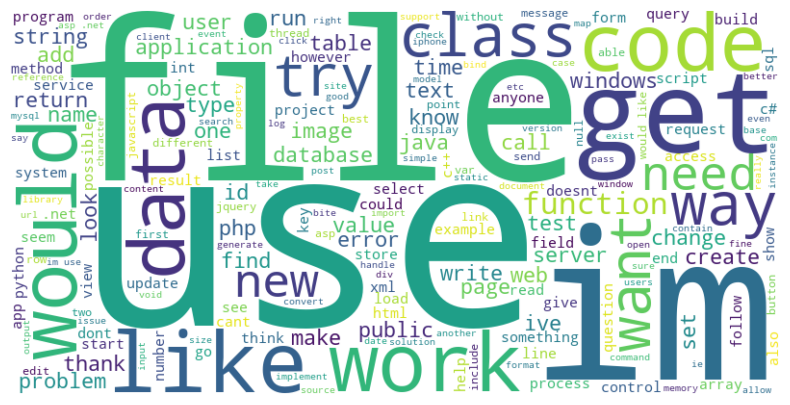

In [46]:
# Sum the TF-IDF values across all documents (rows)
word_tfidf_sum = np.array(X_train_tfidf.sum(axis=0)).flatten()

# Create a dictionary mapping each feature (word) to its summed TF-IDF weight
tfidf_dict = dict(zip(features_names_tfidf, word_tfidf_sum))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Countvectorizer

In [47]:
# les donnes ont déjà été preprocessed, et sont en format string of words.
cv = CountVectorizer(token_pattern = r"(c\#|c\+\+|\.net|\w+)", max_features=1000, max_df=0.8, min_df=5, ngram_range=(1,2))
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

features_names_cv = cv.get_feature_names_out()
#tfidf.vocabulary_

print('Vocabulary size:', len(cv.vocabulary_))
print("Shape of X_train_cv:", X_train_cv.shape)
print("Shape of X_test_cv:", X_test_cv.shape)

Vocabulary size: 1000
Shape of X_train_cv: (40000, 1000)
Shape of X_test_cv: (10000, 1000)


In [48]:
import pickle
# COUNTVECTORIZER ----------------------------------------------------------
# Save the cv
with open('cv_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv, file)

# Save the transformed training data
with open('X_train_cv.pkl', 'wb') as file:
    pickle.dump(X_train_cv, file)

# Save the transformed testing data
with open('X_test_cv.pkl', 'wb') as file:
    pickle.dump(X_test_cv, file)

# Save the feature names
with open('features_names_cv.pkl', 'wb') as file:
    pickle.dump(features_names_cv, file)


    # TF-IDF ----------------------------------------------------------
# Save the TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Save the transformed training data
with open('X_train_tfidf.pkl', 'wb') as file:
    pickle.dump(X_train_tfidf, file)

# Save the transformed testing data
with open('X_test_tfidf.pkl', 'wb') as file:
    pickle.dump(X_test_tfidf, file)

# Save the feature names
with open('features_names_tfidf.pkl', 'wb') as file:
    pickle.dump(features_names_tfidf, file)

## Notes

When using `CountVectorizer`, the parameters `max_df` and `min_df` control the filtering of words based on their document frequency. Adjusting these parameters can help reduce noise and focus on more relevant terms in your text data. Here's how to choose appropriate values for these parameters:

### Understanding `max_df` and `min_df`

1. **`max_df`**:
   - This parameter specifies the maximum document frequency for words. Words that appear in more than `max_df` proportion of the documents will be ignored.
   - Common values:
     - **0.5**: Ignore terms that appear in more than 50% of the documents.
     - **0.7**: Ignore terms that appear in more than 70% of the documents.
     - **1.0**: This means no limit, and all terms will be included.

2. **`min_df`**:
   - This parameter specifies the minimum document frequency for words. Words that appear in fewer than `min_df` documents will be ignored.
   - Common values:
     - **1**: Ignore terms that appear in only one document.
     - **2**: Ignore terms that appear in only two documents.
     - **0.01**: Ignore terms that appear in less than 1% of the documents.

### Suggested Values to Try

1. **Initial Testing**:
   - Start with values like `max_df=0.7` and `min_df=2`. This allows for some common terms while filtering out too-frequent and too-rare words.
   
2. **Iterative Refinement**:
   - **Decrease `max_df`**: If you still find too many common words, lower `max_df` to around **0.5** or even **0.4**.
   - **Increase `min_df`**: If you notice a lot of noise or irrelevant terms, increase `min_df` to **3** or **4**.
   - Test combinations, such as `max_df=0.6` and `min_df=3`, to find a balance.

3. **Based on Data Size**:
   - For smaller datasets, you might set `min_df` to a lower number (like **1** or **2**) to retain more features, while for larger datasets, you can afford to set it higher.

